In [1]:
import pandas as pd
import sklearn
import numpy as np
import util
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression, RidgeCV
import statsmodels.api as sm 
import matplotlib.pylab as plt 
from dmba import regressionSummary, exhaustive_search 
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.metrics import r2_score
from dmba import backward_elimination, forward_selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import QuantileTransformer, quantile_transform

In [3]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 81)

In [4]:
ultimate_df = pd.read_csv('Data/Created Datasets/ALL_merge_truncate3.csv', index_col = 0)

In [4]:
# dataset without hazardous dataset - this dataset is bigger
ultimate_df = pd.read_csv('Data/Created Datasets/Impediments_Feature_Count.csv', index_col = 0)

In [ ]:
ultimate_df['COUNT'].plot(kind = 'hist')

In [201]:
# capping - removing extreme outliers
#ultimate_df['COUNT'] = ultimate_df[ultimate_df['COUNT'] <= 8]

#ultimate_df['COUNT'] = np.log(ultimate_df['COUNT'])

# ultimate_df['COUNT'] = quantile_transform(
#     ultimate_df['COUNT'].to_frame(), n_quantiles=500, output_distribution="normal", copy=True
# ).squeeze()

In [ ]:
ultimate_df['COUNT'].plot(kind = 'hist')

In [6]:
# only downtown

ultimate_df = ultimate_df[(ultimate_df['LATITUDE'] < 43.6688) & (ultimate_df['LONGITUDE'] > -79.46935) & (ultimate_df['LONGITUDE'] < -79.330700)]

In [25]:
ultimate_df.shape

(921, 20)

In [5]:
# not downtown

ultimate_df = ultimate_df[~((ultimate_df['LATITUDE'] < 43.6688) & (ultimate_df['LONGITUDE'] > -79.46935) & (ultimate_df['LONGITUDE'] < -79.330700))]

In [28]:
ultimate_df.shape

(3030, 20)

In [21]:
ultimate_df['LIGHT'] = ultimate_df['LIGHT'].apply(util.lc)
ultimate_df['TRAFFCTL'] = ultimate_df['TRAFFCTL'].apply(util.tc)
ultimate_df['DRIVACT'] = ultimate_df['DRIVACT'].apply(util.actc)
ultimate_df['DRIVCOND'] = ultimate_df['DRIVCOND'].apply(util.condc)
ultimate_df['VEHTYPE'] = ultimate_df['VEHTYPE'].apply(util.vehc)
ultimate_df['INVAGE'] = ultimate_df['INVAGE'].apply(util.agec)
#ultimate_df['MANOEUVER'] = ultimate_df['MANOEUVER'].apply(util.manc)

In [5]:
ultimate_df = ultimate_df.replace('Yes', 1).replace('<Null>', 0).replace('<Null', 0)

In [6]:
ultimate_df['TIME'] = round(ultimate_df['TIME']/100,3)

In [151]:
ultimate_df.columns

Index(['LATITUDE', 'LONGITUDE', 'INVAGE', 'RDSFCOND', 'VISIBILITY', 'LIGHT',
       'TRAFFCTL', 'DRIVACT', 'DRIVCOND', 'VEHTYPE', 'TIME', 'AvgAcceleration',
       'PercentCar', 'PercentHDT', 'PercentLDT', 'PercentMDT', 'PercentMPV',
       'PercentOfVehicles', 'PercentOther', 'COUNT'],
      dtype='object')

In [22]:
X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude','MANOEUVER', 'DRIVACT', 'DRIVCOND', 'TRAFFCTL', 'SPEEDING', 'ALCOHOL', 'REDLIGHT', 'AG_DRIV')]]
# for smaller complete dataset
#X = ultimate_df[['SeverityScore', 'DRIVACT', 'DRIVCOND', 'TRAFFCTL', 'INVAGE', 'AvgAcceleration', 'VEHTYPE', 'VISIBILITY', 'PercentOfVehicles',  'LIGHT']]
# for bigger dataset
#X = ultimate_df[['DRIVACT', 'DRIVCOND','TRAFFCTL', 'INVAGE', 'AvgAcceleration', 'VEHTYPE', 'VISIBILITY', 'PercentOfVehicles']]
#X = ultimate_df[['SeverityScore', 'Cluster', 'AvgAcceleration', 'VISIBILITY', 'PercentOfVehicles',  'LIGHT']]
Y = ultimate_df['COUNT']
X = pd.get_dummies(X, drop_first = True)
#X = X[best_variables_forward]
#X = X[best_variables_forward]


In [23]:
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()

In [24]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  COUNT   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     2.385
Date:                Fri, 11 Mar 2022   Prob (F-statistic):           7.38e-05
Time:                        00:40:20   Log-Likelihood:                -1457.4
No. Observations:                 706   AIC:                             2975.
Df Residuals:                     676   BIC:                             3112.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 3.5632      1.998      1.783      0.075      -0.360       7.487
IncidentsTotal                       -0.0007      0.001     -0.833      0.405      -0.002       0.001
SeverityScore                         9.7197      4.935      1.969      0.049       0.029      19.410
PercentOfVehicles                     5.0140      3.155      1.589      0.112      -1.180      11.208
AvgAcceleration                       0.6054      0.507      1.193      0.233      -0.391       1.602
Cluster                               0.1050      0.030      3.545      0.000       0.047       0.163
TIME                                 -0.0109      0.014     -0.783      0.434      -0.038       0.016
INVAGE_Children                       1.7467      2.125      0.822      0.411      -2.426       5.919
INVAGE_Senior                         0.0326      0.236      0.138      0.890      -0.431       0.497
INVAGE_Super Senior                   0.0545      0.239      0.228      0.820      -0.415       0.524
INVAGE_Young Adult                   -0.3153      0.206     -1.532      0.126      -0.719       0.089
RDSFCOND_Dry                         -0.3316      1.042     -0.318      0.750      -2.377       1.714
RDSFCOND_Loose Snow                  -0.7110      1.231     -0.577      0.564      -3.128       1.706
RDSFCOND_Other                       -0.8836      1.337     -0.661      0.509      -3.508       1.741
RDSFCOND_Packed Snow                  0.2767      1.638      0.169      0.866      -2.940       3.494
RDSFCOND_Slush                       -1.5567      1.280     -1.217      0.224      -4.069       0.956
RDSFCOND_Wet                         -0.5084      1.042     -0.488      0.626      -2.554       1.537
VISIBILITY_Clear                     -0.7861      1.039     -0.757      0.449      -2.826       1.253
VISIBILITY_Fog, Mist, Smoke, Dust    -1.4815      2.077     -0.713      0.476      -5.559       2.596
VISIBILITY_Freezing Rain             -1.5186      1.525     -0.996      0.320      -4.513       1.476
VISIBILITY_Other                      0.5083      1.334      0.381      0.703      -2.110       3.127
VISIBILITY_Rain                       0.0667      1.056      0.063      0.950      -2.007       2.140
VISIBILITY_Snow                      -0.5033      1.135     -0.444      0.657      -2.731       1.724
LIGHT_Dark                           -0.2783      0.228     -1.222      0.222      -0.725       0.169
LIGHT_Dawn                            3.0429      1.394      2.183      0.029       0.306       5.780
LIGHT_Daylight                       -0.1180      0.187     -0.631      0.528      -0.485       0.249
LIGHT_Dusk                            1.1139      0.713      1.563      0.118      -0.285       2.513
VEHTYPE_Medium-size Veh

<AxesSubplot:xlabel='COUNT'>

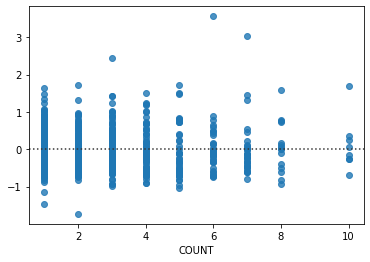

In [17]:
sns.residplot(y = results.predict(X), x = Y)

In [54]:
regressionSummary(Y, results.predict(X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1.8406
            Mean Absolute Error (MAE) : 1.4253
          Mean Percentage Error (MPE) : -44.9880
Mean Absolute Percentage Error (MAPE) : 70.7520


In [ ]:
#results.params.reset_index().rename(columns = {'index': 'Variables', '0': 'Coefficients'})

In [15]:
#X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude',  'PercentCar', 'PercentHDT', 'PercentLDT', 'PercentMDT', 'PercentMPV', 'PercentOther', 'VEHTYPE', 'INVAGE')]]
# X = ultimate_df[['SeverityScore', 'DRIVACT', 'DRIVCOND', 'TRAFFCTL', 'INVAGE', 'AvgAcceleration', 'VEHTYPE', 'VISIBILITY', 'PercentOfVehicles',  'LIGHT']]

# X = pd.get_dummies(X, drop_first = True)

# need to remove the columns with 0s in their names
# the columns with 0 in their names are the ones which are structural zeros/not applicables

#X = X[[col for col in X.columns if '0' not in col]]

In [16]:
X.shape

(706, 44)

In [25]:
Y = ultimate_df['COUNT']

train_X, valid_X, train_Y, valid_Y =  train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [26]:
# Does the model perform better than the null model?
# Our created models must be able to beat this:
# I'm comparing valid_Y to the mean of COUNT. 

regressionSummary(valid_Y, np.repeat(Y.mean(), valid_Y.shape))


Regression statistics

                      Mean Error (ME) : 0.1343
       Root Mean Squared Error (RMSE) : 2.1135
            Mean Absolute Error (MAE) : 1.6914
          Mean Percentage Error (MPE) : -54.8264
Mean Absolute Percentage Error (MAPE) : 86.1793


In [27]:
linear_model = LinearRegression()
linear_model.fit(train_X, train_Y)

LinearRegression()

In [28]:
print(regressionSummary(train_Y, linear_model.predict(train_X)))
regressionSummary(valid_Y, linear_model.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1.8696
            Mean Absolute Error (MAE) : 1.4531
          Mean Percentage Error (MPE) : -48.5644
Mean Absolute Percentage Error (MAPE) : 75.0999
None

Regression statistics

                      Mean Error (ME) : 0.0346
       Root Mean Squared Error (RMSE) : 2.1994
            Mean Absolute Error (MAE) : 1.7262
          Mean Percentage Error (MPE) : -55.2275
Mean Absolute Percentage Error (MAPE) : 86.2695


Estimating transforms: 100%|██████████| 1000/1000 [00:02<00:00, 470.69it/s]


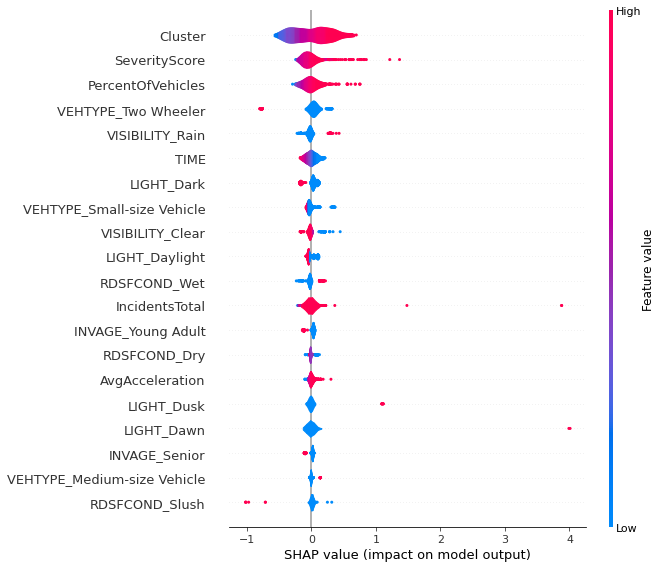

In [29]:
explainer = shap.Explainer(linear_model, masker=shap.maskers.Impute(data= X),
                           feature_names= X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type = 'violin')

In [22]:
pd.DataFrame({'Actual': valid_Y, 'Predicted': linear_model.predict(valid_X)})

,Actual,Predicted
605,1,2.919491
425,2,3.627372
334,1,2.210006
457,4,3.600056
187,1,1.024437
...,...,...
119,4,3.859712
82,6,3.828721
615,4,2.878520
311,3,1.302319


<AxesSubplot:xlabel='COUNT'>

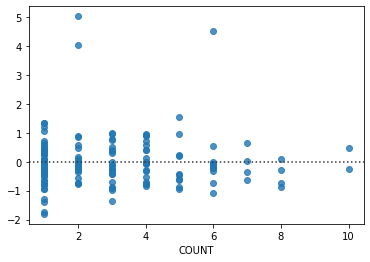

In [30]:
sns.residplot(y = linear_model.predict(valid_X), x = valid_Y)

In [31]:
pd.DataFrame({'Feature': train_X.columns, 'coefficients': linear_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
2,SeverityScore,6.264055e+00
3,PercentOfVehicles,6.190667e+00
24,LIGHT_Dawn,3.826046e+00
26,LIGHT_Dusk,1.049195e+00
14,RDSFCOND_Packed Snow,5.278267e-01
4,AvgAcceleration,1.984963e-01
5,Cluster,1.152758e-01
1,IncidentsTotal,2.101465e-03
7,INVAGE_Children,2.839395e-14
18,"VISIBILITY_Fog, Mist, Smoke, Dust",4.440892e-15


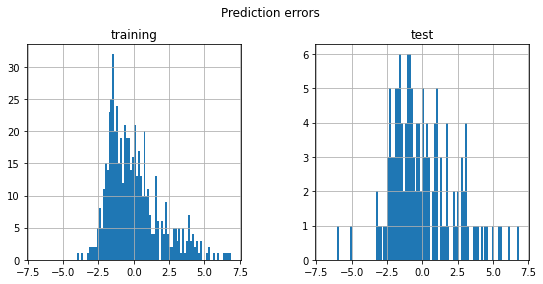

In [32]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - linear_model.predict(train_X), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - linear_model.predict(valid_X), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#fig.text(0.5, 0.05, 'Skew: ' + str(pred_error_train.skew()), ha = 'center')
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

In [33]:
pred_error_train.skew()

residual    1.049683
dtype: float64

In [34]:
pred_error_test.skew()

residual    0.663543
dtype: float64

In [35]:
r2_score(valid_Y, linear_model.predict(valid_X))

-0.08726651855861234

In [36]:
# these functions assume the existence of a train_Y 
def train_model(variables): 
    if len(variables) == 0: 
        return None 
    model = LinearRegression() 
    model.fit(train_X[variables], train_Y) 
    return model 
    
def score_model(model, variables): 
    if len(variables) == 0: 
        return AIC_score(train_Y, [train_Y.mean()] * len(train_Y), model, df=1) 
    return AIC_score(train_Y, model.predict(train_X[variables]), model) 

In [37]:
forwards_model, best_variables_forward = forward_selection(train_X.columns, train_model, score_model, verbose = True)

Variables: const, IncidentsTotal, SeverityScore, PercentOfVehicles, AvgAcceleration, Cluster, TIME, INVAGE_Children, INVAGE_Senior, INVAGE_Super Senior, INVAGE_Young Adult, RDSFCOND_Dry, RDSFCOND_Loose Snow, RDSFCOND_Other, RDSFCOND_Packed Snow, RDSFCOND_Slush, RDSFCOND_Wet, VISIBILITY_Clear, VISIBILITY_Fog, Mist, Smoke, Dust, VISIBILITY_Freezing Rain, VISIBILITY_Other, VISIBILITY_Rain, VISIBILITY_Snow, LIGHT_Dark, LIGHT_Dawn, LIGHT_Daylight, LIGHT_Dusk, VEHTYPE_Medium-size Vehicle, VEHTYPE_Other, VEHTYPE_Small-size Vehicle, VEHTYPE_Two Wheeler
Start: score=2370.73, constant
Step: score=2358.71, add Cluster
Step: score=2350.16, add VISIBILITY_Rain
Step: score=2346.83, add VEHTYPE_Two Wheeler
Step: score=2342.90, add VEHTYPE_Small-size Vehicle
Step: score=2340.46, add PercentOfVehicles
Step: score=2338.41, add LIGHT_Dawn
Step: score=2337.11, add SeverityScore
Step: score=2336.47, add LIGHT_Dusk
Step: score=2336.23, add RDSFCOND_Slush
Step: score=2336.23, add None


In [38]:
print(regressionSummary(train_Y, forwards_model.predict(train_X[best_variables_forward])))
regressionSummary(valid_Y, forwards_model.predict(valid_X[best_variables_forward]))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1.8827
            Mean Absolute Error (MAE) : 1.4613
          Mean Percentage Error (MPE) : -49.1131
Mean Absolute Percentage Error (MAPE) : 75.5476
None

Regression statistics

                      Mean Error (ME) : 0.0531
       Root Mean Squared Error (RMSE) : 2.0934
            Mean Absolute Error (MAE) : 1.6605
          Mean Percentage Error (MPE) : -54.3675
Mean Absolute Percentage Error (MAPE) : 84.1841


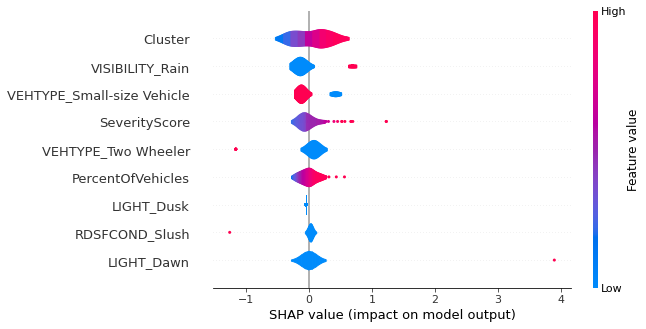

In [39]:
masker = shap.maskers.Independent(data= X[best_variables_forward])
explainer = shap.Explainer(forwards_model, masker= masker,
                           feature_names= valid_X[best_variables_forward].columns, algorithm="linear")
shap_values = explainer.shap_values(valid_X[best_variables_forward])
shap.summary_plot(shap_values, valid_X[best_variables_forward], plot_type = 'violin')

In [40]:
pd.DataFrame({'Feature': best_variables_forward, 'coefficients': forwards_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
6,SeverityScore,9.649100
4,PercentOfVehicles,5.870952
5,LIGHT_Dawn,3.891688
7,LIGHT_Dusk,1.087243
1,VISIBILITY_Rain,0.834367
0,Cluster,0.113486
3,VEHTYPE_Small-size Vehicle,-0.544512
2,VEHTYPE_Two Wheeler,-1.231699
8,RDSFCOND_Slush,-1.279436


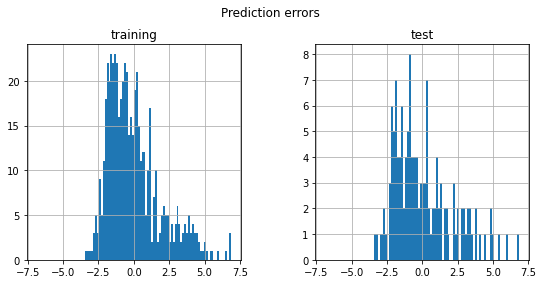

In [41]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - forwards_model.predict(train_X[best_variables_forward]), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - forwards_model.predict(valid_X[best_variables_forward]), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

In [42]:
pred_error_train.skew()

residual    1.088931
dtype: float64

In [43]:
pred_error_test.skew()

residual    0.955445
dtype: float64

<AxesSubplot:xlabel='COUNT'>

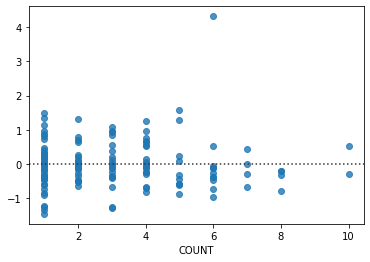

In [44]:
sns.residplot(y = forwards_model.predict(valid_X[best_variables_forward]), x = valid_Y)

In [45]:
backwards_model, best_variables_backward = backward_elimination(train_X.columns, train_model, score_model, verbose = False)

In [46]:
print(regressionSummary(train_Y, backwards_model.predict(train_X[best_variables_backward])))
regressionSummary(valid_Y, backwards_model.predict(valid_X[best_variables_backward]))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1.8867
            Mean Absolute Error (MAE) : 1.4620
          Mean Percentage Error (MPE) : -49.2122
Mean Absolute Percentage Error (MAPE) : 75.5676
None

Regression statistics

                      Mean Error (ME) : 0.0477
       Root Mean Squared Error (RMSE) : 2.0887
            Mean Absolute Error (MAE) : 1.6583
          Mean Percentage Error (MPE) : -54.5409
Mean Absolute Percentage Error (MAPE) : 84.1906


In [47]:
pd.DataFrame({'Feature': best_variables_backward, 'coefficients': backwards_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
0,SeverityScore,9.246339
1,PercentOfVehicles,5.714475
5,LIGHT_Dawn,3.894253
6,LIGHT_Dusk,1.154359
2,Cluster,0.114768
7,VEHTYPE_Small-size Vehicle,-0.544491
4,VISIBILITY_Clear,-0.658312
8,VEHTYPE_Two Wheeler,-1.219890
3,RDSFCOND_Slush,-1.627201


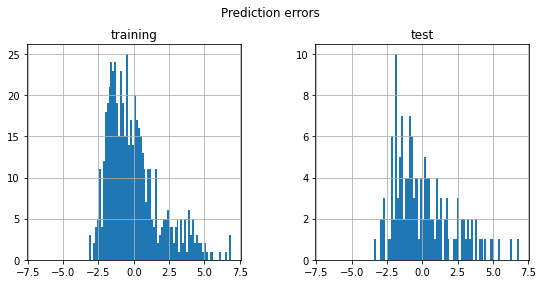

In [48]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - backwards_model.predict(train_X[best_variables_backward]), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - backwards_model.predict(valid_X[best_variables_backward]), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

In [49]:
pred_error_train.skew()

residual    1.114673
dtype: float64

In [50]:
pred_error_test.skew()

residual    0.956529
dtype: float64

<AxesSubplot:xlabel='COUNT'>

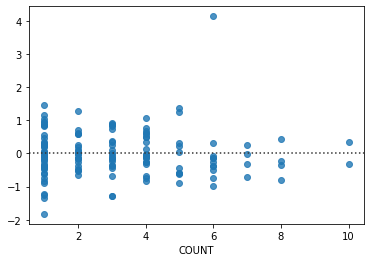

In [51]:
sns.residplot(y = backwards_model.predict(valid_X[best_variables_backward]), x = valid_Y)

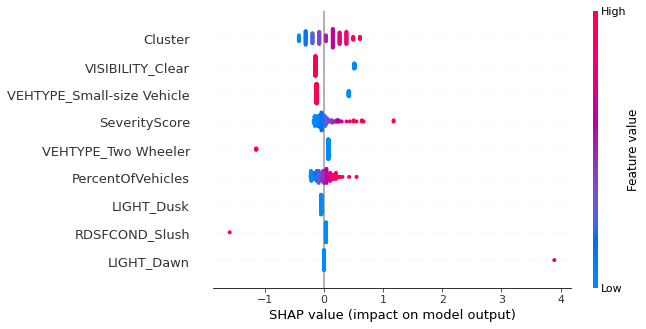

In [52]:
masker = shap.maskers.Independent(data= X[best_variables_backward])
explainer = shap.Explainer(backwards_model, masker= masker,
                           feature_names= valid_X[best_variables_backward].columns, algorithm="linear")
shap_values = explainer.shap_values(valid_X[best_variables_backward])
shap.summary_plot(shap_values, valid_X[best_variables_backward])

In [73]:
ultimate_df = pd.read_csv('Data/Created Datasets/ALL_merge_truncate3.csv', index_col = 0)
ultimate_df['LIGHT'] = ultimate_df['LIGHT'].apply(util.lc)
ultimate_df['TRAFFCTL'] = ultimate_df['TRAFFCTL'].apply(util.tc)
ultimate_df['DRIVACT'] = ultimate_df['DRIVACT'].apply(util.actc)
ultimate_df['DRIVCOND'] = ultimate_df['DRIVCOND'].apply(util.condc)
ultimate_df['VEHTYPE'] = ultimate_df['VEHTYPE'].apply(util.vehc)
ultimate_df['INVAGE'] = ultimate_df['INVAGE'].apply(util.agec)
X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude','DRIVACT', 'DRIVCOND', 'TRAFFCTL', 'SPEEDING', 'ALCOHOL', 'REDLIGHT', 'AG_DRIV')]]
# for smaller complete dataset
#X = ultimate_df[['SeverityScore', 'DRIVACT', 'DRIVCOND', 'TRAFFCTL', 'INVAGE', 'AvgAcceleration', 'VEHTYPE', 'VISIBILITY', 'PercentOfVehicles',  'LIGHT']]
# for bigger dataset

#ultimate_df['MANOEUVER'] = ultimate_df['MANOEUVER'].apply(util.manc)
X = pd.get_dummies(X, drop_first = True)

#X = sm.add_constant(X)

Y = ultimate_df['COUNT']

train_X, valid_X, train_Y, valid_Y =  train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [74]:
ridge_model = RidgeCV()
ridge_model.fit(train_X, train_Y)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [75]:
print(regressionSummary(train_Y, ridge_model.predict(train_X)))
regressionSummary(valid_Y, ridge_model.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1.8932
            Mean Absolute Error (MAE) : 1.4729
          Mean Percentage Error (MPE) : -50.4355
Mean Absolute Percentage Error (MAPE) : 76.7858
None

Regression statistics

                      Mean Error (ME) : 0.0344
       Root Mean Squared Error (RMSE) : 2.2307
            Mean Absolute Error (MAE) : 1.7617
          Mean Percentage Error (MPE) : -57.8357
Mean Absolute Percentage Error (MAPE) : 89.4893


<AxesSubplot:xlabel='COUNT'>

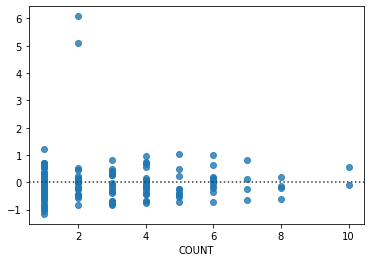

In [76]:
sns.residplot(y = ridge_model.predict(valid_X), x = valid_Y)

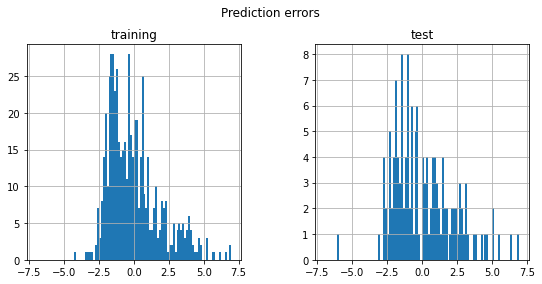

In [77]:
pred_error_train = pd.DataFrame({ 
 'residual': train_Y - ridge_model.predict(train_X), 
 'data set': 'training' 
}) 
pred_error_test = pd.DataFrame({ 
 'residual': valid_Y - ridge_model.predict(valid_X), 
 'data set': 'test' 
}) 

#boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True) 
fig, axes = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(9, 4) 
common = {'bins': 100, 'range': [-pred_error_test['residual'].max(), pred_error_test['residual'].max()]} 
pred_error_train.hist(ax=axes[0], **common) 
pred_error_test.hist(ax=axes[1], **common) 
#boxdata_df.boxplot(ax=axes[2], by = 'data set') 
axes[0].set_title('training') 
axes[1].set_title('test') 
#axes[2].set_title(' ') 
#axes[2].set_ylim(-50, 50) 
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.1, top=0.85, wspace=0.35) 
#plt.show() 

In [78]:
pred_error_train.skew()

residual    1.083409
dtype: float64

In [79]:
pred_error_test.skew()

residual    0.476796
dtype: float64

In [82]:
r2_score(valid_Y, ridge_model.predict(valid_X))

-0.11847734493921269

In [80]:
pd.DataFrame({'Feature': X.columns, 'coefficients': ridge_model.coef_}).sort_values(by = 'coefficients', ascending = False)

,Feature,coefficients
25,LIGHT_Dusk,0.452667
20,VISIBILITY_Rain,0.403059
23,LIGHT_Dawn,0.352853
3,AvgAcceleration,0.284758
15,RDSFCOND_Wet,0.252977
2,PercentOfVehicles,0.221138
10,RDSFCOND_Dry,0.215740
13,RDSFCOND_Packed Snow,0.141185
4,Cluster,0.119003
1,SeverityScore,0.101441


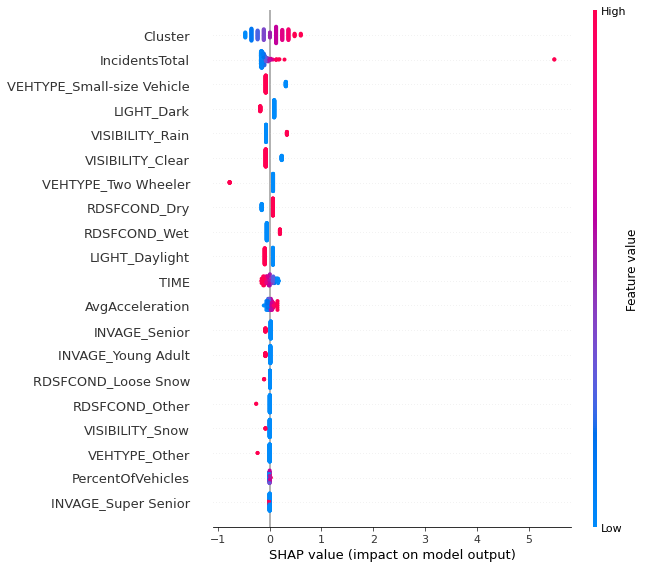

In [81]:
masker = shap.maskers.Independent(data= valid_X)
explainer = shap.Explainer(ridge_model, masker= masker,
                           feature_names= valid_X.columns, algorithm="auto")
shap_values = explainer.shap_values(valid_X)
shap.summary_plot(shap_values, valid_X)